In [112]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import pickle
import plotly.express as px

In [93]:
traindata = pd.read_excel('Data_Train.xlsx')

In [94]:
traindata

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


## Preparation

In [95]:
traindata.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [96]:
traindata[traindata.Route.isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [97]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [98]:
traindata.Additional_Info = traindata.Additional_Info.replace('No Info', 'No info')

traindata['Journey_day'] = pd.to_datetime(traindata.Date_of_Journey, format='%d/%m/%Y').dt.day
traindata['Journey_month'] = pd.to_datetime(traindata.Date_of_Journey, format='%d/%m/%Y').dt.month
traindata.drop('Date_of_Journey', inplace=True, axis=1)

traindata['Dep_hour'] = pd.to_datetime(traindata.Dep_Time, format='%H:%M').dt.hour
traindata['Dep_min'] = pd.to_datetime(traindata.Dep_Time, format='%H:%M').dt.minute
traindata.drop('Dep_Time', inplace=True, axis=1)

In [99]:
pd.to_datetime(traindata['Arrival_Time'], format='mixed')

0       2023-03-22 01:10:00
1       2023-06-21 13:15:00
2       2023-06-10 04:25:00
3       2023-06-21 23:30:00
4       2023-06-21 21:35:00
                ...        
10678   2023-06-21 22:25:00
10679   2023-06-21 23:20:00
10680   2023-06-21 11:20:00
10681   2023-06-21 14:10:00
10682   2023-06-21 19:15:00
Name: Arrival_Time, Length: 10683, dtype: datetime64[ns]

In [100]:
hour = []
minute = []
total_min = []
for i in range(len(traindata.Duration)):
    if len(traindata.Duration[i].split()) < 2:
        hour.append(traindata.Duration[i].split()[0][:-1])
        minute.append(0)
    else:
        hour.append(traindata.Duration[i].split()[0][:-1])
        minute.append(traindata.Duration[i].split()[1][:-1])

for i in range(len(hour)):
    hour[i] = int(hour[i])*60
    minute[i] = int(minute[i])
    total_min.append(hour[i] + minute[i])
traindata['Duration_mins'] = total_min
traindata.drop('Duration',axis=1,inplace=True)

In [101]:
traindata

,Airline,Source,Destination,Route,Arrival_Time,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,01:10 22 Mar,non-stop,No info,3897,24,3,22,20,170
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,13:15,2 stops,No info,7662,1,5,5,50,445
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,04:25 10 Jun,2 stops,No info,13882,9,6,9,25,1140
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,23:30,1 stop,No info,6218,12,5,18,5,325
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,21:35,1 stop,No info,13302,1,3,16,50,285
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,CCU → BLR,22:25,non-stop,No info,4107,9,4,19,55,150
10679,Air India,Kolkata,Banglore,CCU → BLR,23:20,non-stop,No info,4145,27,4,20,45,155
10680,Jet Airways,Banglore,Delhi,BLR → DEL,11:20,non-stop,No info,7229,27,4,8,20,180
10681,Vistara,Banglore,New Delhi,BLR → DEL,14:10,non-stop,No info,12648,1,3,11,30,160


## Exploration

### Which airlines have the highest and lowest average prices?

In [102]:
traindata.groupby('Airline')['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Airline,,,,,,,,
Air Asia,319.0,5590.260188,2027.362290,3383.0,4282.0,5162.0,6451.00,13774.0
Air India,1752.0,9611.210616,3900.952942,2050.0,6896.0,9443.0,12219.00,31945.0
GoAir,194.0,5861.056701,2703.585767,3398.0,3898.0,5135.0,6811.25,22794.0
IndiGo,2053.0,5673.682903,2264.142168,2227.0,4226.0,5000.0,6494.00,22153.0
Jet Airways,3849.0,11643.923357,4258.940578,1840.0,9134.0,11467.0,14151.00,54826.0
Jet Airways Business,6.0,58358.666667,11667.596748,46490.0,52243.0,54747.0,61122.50,79512.0
Multiple carriers,1196.0,10902.678094,3721.234997,5797.0,7723.0,10197.0,13587.00,36983.0
Multiple carriers Premium economy,13.0,11418.846154,1717.153936,9845.0,10161.0,11269.0,11269.00,14629.0
SpiceJet,818.0,4338.284841,1849.922514,1759.0,3574.5,3873.0,4760.00,23267.0


### What are the most popular routes based on the frequency of flights?

In [103]:
traindata.Route.value_counts()

Route
DEL → BOM → COK          2376
BLR → DEL                1552
CCU → BOM → BLR           979
CCU → BLR                 724
BOM → HYD                 621
                         ... 
CCU → VTZ → BLR             1
CCU → IXZ → MAA → BLR       1
BOM → COK → MAA → HYD       1
BOM → CCU → HYD             1
BOM → BBI → HYD             1
Name: count, Length: 128, dtype: int64

### How does the price of flights vary based on the number of stops?

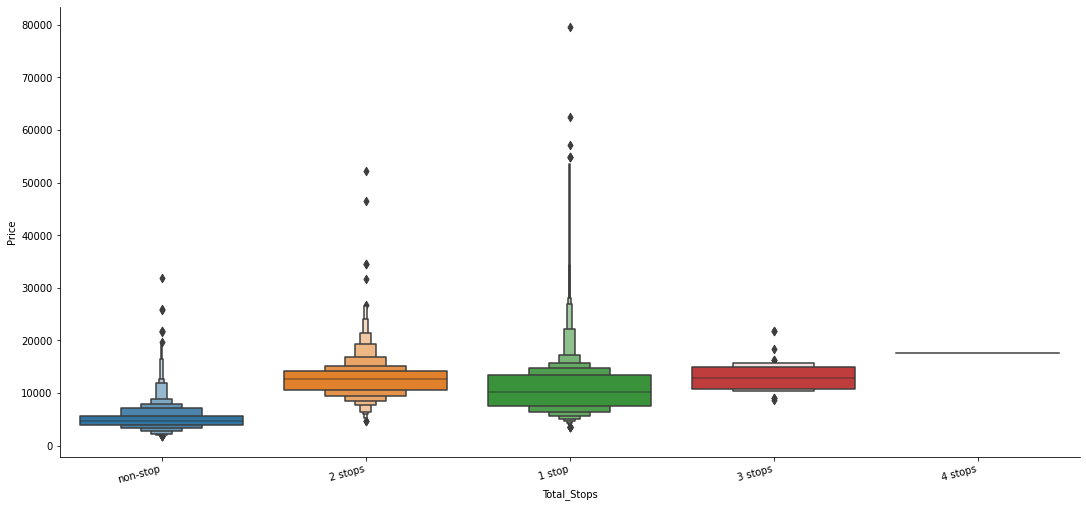

In [104]:
sns.catplot(x='Total_Stops', y='Price', data=traindata, kind='boxen', aspect=3)
plt.xticks(rotation=15, ha="right")
fig = plt.gcf()
fig.set_figwidth(15)
fig.set_figheight(7)

### What are the prices based on the number of stops?

In [105]:
traindata.groupby('Total_Stops')['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Total_Stops,,,,,,,,
1 stop,5625.0,10594.123556,4281.645993,3480.0,7480.0,10262.0,13364.0,79512.0
2 stops,1520.0,12715.807895,3383.983396,4647.0,10676.0,12760.0,14237.0,52285.0
3 stops,45.0,13112.000000,2963.224265,8607.0,10703.0,12954.0,14960.0,21829.0
4 stops,1.0,17686.000000,NaN,17686.0,17686.0,17686.0,17686.0,17686.0
non-stop,3491.0,5024.900315,2077.586642,1759.0,3858.0,4667.0,5678.0,31945.0


### What are the frequency of stops by each airline?

In [106]:
c = ['non-stop', '1 stop', '2 stops', '3 stops', '4 stops']
pd.crosstab(traindata.Airline, traindata.Total_Stops, margins=True)[c]

Total_Stops,non-stop,1 stop,2 stops,3 stops,4 stops
Airline,,,,,
Air Asia,181,129,9,0,0
Air India,417,540,756,37,1
GoAir,92,102,0,0,0
IndiGo,1241,793,19,0,0
Jet Airways,623,2535,691,0,0
Jet Airways Business,0,4,2,0,0
Multiple carriers,0,1145,43,8,0
Multiple carriers Premium economy,0,13,0,0,0
SpiceJet,670,148,0,0,0


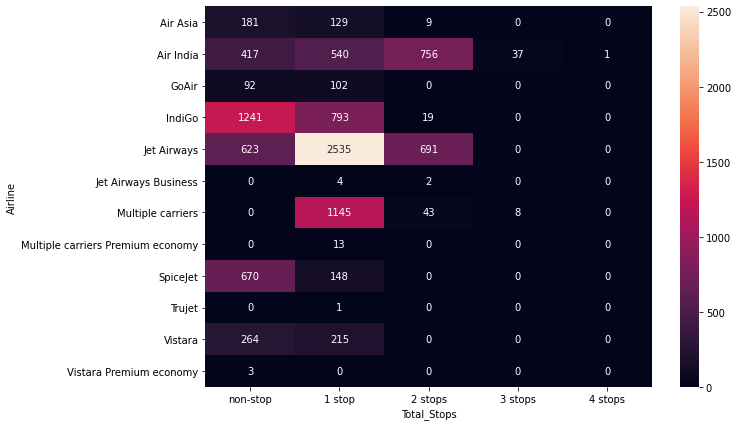

In [107]:
sns.heatmap(pd.crosstab(traindata.Airline, traindata.Total_Stops)[c], annot=True, fmt='g')
fig = plt.gcf()
fig.set_figwidth(10)
fig.set_figheight(7)

### Are there any specific additional information notes that are associated with higher-priced flights?

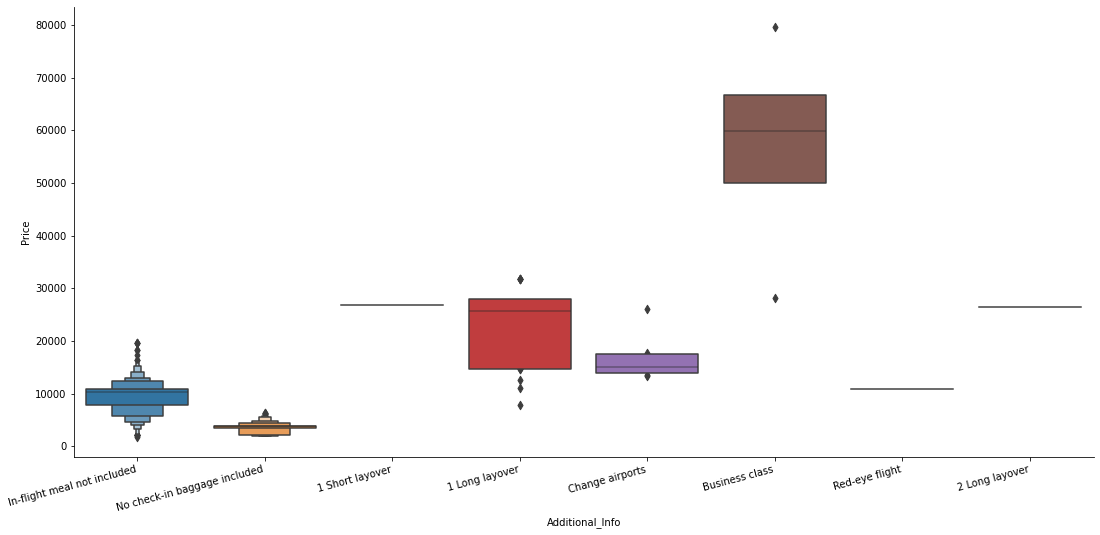

In [108]:
sns.catplot(x='Additional_Info', y='Price', data=traindata[traindata.Additional_Info != 'No info'], kind='boxen', aspect=3)
plt.xticks(rotation=15, ha="right")
fig = plt.gcf()
fig.set_figwidth(15)
fig.set_figheight(7)

### Which months have the highest and lowest average prices for flights?

In [109]:
traindata.groupby('Journey_month')['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Journey_month,,,,,,,,
3,2724.0,10673.205580,6047.738655,1759.0,6427.0,9650.5,13778.0,79512.0
4,1079.0,5770.847081,2265.636265,1759.0,4423.0,5073.0,6589.0,17531.0
5,3466.0,9127.247548,3991.183784,1965.0,5320.0,8891.0,12723.0,34273.0
6,3414.0,8828.796134,3745.209442,1965.0,5636.0,8610.0,11789.0,18804.0


### Are there any patterns or trends in flight durations based on the departure time?

In [110]:
traindata.head()

,Airline,Source,Destination,Route,Arrival_Time,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,01:10 22 Mar,non-stop,No info,3897,24,3,22,20,170
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,13:15,2 stops,No info,7662,1,5,5,50,445
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,04:25 10 Jun,2 stops,No info,13882,9,6,9,25,1140
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,23:30,1 stop,No info,6218,12,5,18,5,325
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,21:35,1 stop,No info,13302,1,3,16,50,285


In [111]:
traindata.Dep_hour.unique()

array([22,  5,  9, 18, 16,  8, 11, 20, 21, 17, 14,  4,  7, 10, 15,  6, 19,
       23, 13,  2, 12,  0,  1,  3])

In [118]:
px.scatter(traindata, x="Dep_hour", y="Dep_min", size="Duration_mins")

In [130]:
traindata.groupby(['Total_Stops', 'Airline'])['Duration_mins'].describe()

count         mean   
Total_Stops Airline                                                  
1 stop      Air Asia                            129.0   602.635659  \
            Air India                           540.0   974.842593   
            GoAir                               102.0   414.705882   
            IndiGo                              793.0   483.051702   
            Jet Airways                        2535.0   926.238659   
            Jet Airways Business                  4.0   330.000000   
            Multiple carriers                  1145.0   625.772926   
            Multiple carriers Premium economy    13.0   606.538462   
            SpiceJet                            148.0   348.614865   
            Trujet                                1.0   195.000000   
            Vistara                             215.0  1132.000000   
2 stops     Air Asia                              9.0   494.444444   
            Air India                           756.0  1320.648148   
            IndiGo                               19.0   777.105263   
            Jet Airways                         691.0  1201.259045   
            Jet Airways Business                  2.0   500.000000   
            Multiple carriers                    43.0   618.139535   
3 stops     Air India                            37.0  1737.972973   
            Multiple carriers                     8.0   666.250000   
4 stops     Air India                             1.0  1770.000000   
non-stop    Air Asia                            181.0   159.723757   
            Air India                           417.0   145.215827   
            GoAir                                92.0   170.652174   
            IndiGo                             1241.0   151.583400   
            Jet Airways                         623.0   148.539326   
            SpiceJet                            670.0   140.902985   
            Vistara                             264.0   163.863636   
            Vistara Premium economy               3.0   153.333333   

                                                      std     min     25%   
Total_Stops Airline                                                         
1 stop      Air Asia                           256.265303   215.0   330.0  \
            Air India                          412.329150   240.0   675.0   
            GoAir                               85.032968   265.0   355.0   
            IndiGo                             221.297297   220.0   305.0   
            Jet Airways                        414.918765   280.0   585.0   
            Jet Airways Business                52.915026   280.0   295.0   
            Multiple carriers                  156.957777   375.0   480.0   
            Multiple carriers Premium economy  173.893941   395.0   440.0   
            SpiceJet                            74.971244   270.0   295.0   
            Trujet                                    NaN   195.0   195.0   
            Vistara                            406.259953   355.0   790.0   
2 stops     Air Asia                            16.666667   450.0   500.0   
            Air India                          428.359929   150.0  1045.0   
            IndiGo                             181.936465   335.0   665.0   
            Jet Airways                        464.367584   420.0   810.0   
            Jet Airways Business                 0.000000   500.0   500.0   
            Multiple carriers                  146.222365   460.0   465.0   
3 stops     Air India                          537.006181   685.0  1470.0   
            Multiple carriers                  139.738276   565.0   565.0   
4 stops     Air India                                 NaN  1770.0  1770.0   
non-stop    Air Asia                             8.687855   150.0   150.0   
            Air India                           37.515400    75.0   135.0   
            GoAir                                5.147142   155.0   165.0   
            IndiGo    

In [131]:
traindata.groupby('Dep_hour')['Duration_mins'].describe()

,count,mean,std,min,25%,50%,75%,max
Dep_hour,,,,,,,,
0,40.0,413.875000,452.203278,165.0,170.0,175.0,495.00,1685.0
1,37.0,175.945946,106.633054,90.0,165.0,165.0,165.00,795.0
2,194.0,513.221649,468.919005,85.0,90.0,345.0,762.50,1570.0
3,24.0,725.625000,268.988898,80.0,525.0,910.0,913.75,925.0
4,170.0,483.588235,373.137276,155.0,170.0,420.0,845.00,1660.0
5,629.0,802.368839,670.260870,80.0,170.0,665.0,1375.00,2820.0
6,687.0,633.682678,522.381339,80.0,165.0,475.0,900.00,2245.0
7,867.0,587.814302,419.316409,85.0,180.0,540.0,825.00,2170.0
8,697.0,662.826399,423.951855,85.0,290.0,645.0,780.00,2345.0


### Is there any correlation between the day of the journey and the price of flights?

In [133]:
traindata.groupby(['Journey_month','Journey_day'])['Price'].describe()

count          mean           std     min   
Journey_month Journey_day                                              
3             1            199.0  19517.849246  10668.819328  4622.0  \
              3            315.0  12033.615873   5161.810602  4050.0   
              6            403.0  13975.727047   4729.198630  3175.0   
              9            302.0  10391.784768   4689.342209  3603.0   
              12           142.0  11607.154930   3556.067541  4049.0   
              15           162.0   7137.796296   3666.487002  2050.0   
              18           156.0   8926.858974   6780.571478  1965.0   
              21           423.0   8011.418440   2922.818886  1759.0   
              24           323.0   8755.755418   4076.631311  2050.0   
              27           299.0   7406.575251   2885.754499  1759.0   
4             1            257.0   7448.124514   3146.129277  1965.0   
              3            110.0   4395.163636   1209.036560  1759.0   
              6            100.0   4805.360000    916.200670  3383.0   
              9            125.0   6462.984000   2822.208075  3419.0   
              12            63.0   5124.031746   1036.971381  3841.0   
              15            89.0   5126.101124    991.380007  3809.0   
              18            67.0   5344.940299   1155.456461  3841.0   
              21            82.0   5573.000000   1049.098649  3943.0   
              24            92.0   4965.500000    986.008442  3383.0   
              27            94.0   5209.989362   1028.405944  3383.0   
5             1            277.0   8692.072202   3930.288418  1965.0   
              3             90.0   4671.255556   1470.480870  1965.0   
              6            282.0   8720.407801   3977.905128  1965.0   
              9            484.0   9763.592975   4032.735704  1965.0   
              12           259.0   8522.447876   3925.184185  1965.0   
              15           405.0   8771.612346   3654.892417  1965.0   
              18           504.0   9860.662698   3811.706369  1965.0   
              21           497.0   9845.796781   3938.098825  1965.0   
              24           286.0   8777.720280   4001.691873  1965.0   
              27           382.0   9133.007853   4197.156764  1965.0   
6             1            342.0   8987.330409   3827.190764  1965.0   
              3            333.0   8925.921922   3778.434961  1965.0   
              6            503.0   9567.029821   3614.378535  1965.0   
              9            495.0   9611.317172   3546.588012  1965.0   
              12           493.0   9210.277890   3499.758004  2017.0   
              15           328.0   8636.332317   3703.873495  1965.0   
              18           105.0   4707.371429   1798.607379  1965.0   
              21           109.0   4950.724771   1784.987695  1965.0   
              24           351.0   8663.404558   3717.011433  1965.0   
              27           355.0   8669.157746   3841.408689  1965.0   

                                25%      50%       75%      max  
Journey_month Journey_day                                        
3             1            11812.00  18387.0  26890.00  79512.0  
              3             7648.00  11762.0  15141.00  46490.0  
              6            11915.00  15077.0  16736.00  52285.0  
              9             6781.25   9575.0  14053.00  34608.0  
              12           11087.00  12014.0  13817.00  23843.0  
              15            5399.25   6657.5   8855.00  27210.0  
              18            4382.25  10909.0  12284.00  54826.0  
              21            6041.00   7738.0   9707.50  14629.0  
              24            5340.00   8033.0  12173.00  31945.0  
              27            5678.00   6681.0   9254.00  12537.0  
4             1             4957.00   7064.0   9258.00  14151.0  
              3             3925.00   4450.5   5021.75   8040.0  
              6             4174.00   4641.5   5177.00   7229.0  
            

### Are there any notable differences in flight prices based on the source and destination cities?

In [136]:
traindata.groupby(['Source','Destination'])['Price'].describe()

count          mean          std     min     25%   
Source   Destination                                                      
Banglore Delhi        1265.0   5143.918577  1346.487105  3257.0  4030.0  \
         New Delhi     932.0  11917.716738  7416.086298  3383.0  7240.0   
Chennai  Kolkata       381.0   4789.892388  2190.219021  3145.0  3597.0   
Delhi    Cochin       4537.0  10539.439057  3781.948512  3876.0  7202.0   
Kolkata  Banglore     2871.0   9158.389411  3741.997070  3480.0  5192.0   
Mumbai   Hyderabad     697.0   5059.708752  4100.504092  1759.0  2647.0   

                          50%      75%      max  
Source   Destination                             
Banglore Delhi         4823.0   5911.0   8541.0  
         New Delhi    10898.5  13817.0  79512.0  
Chennai  Kolkata       3850.0   5277.0  19630.0  
Delhi    Cochin       10262.0  13344.0  52285.0  
Kolkata  Banglore      9345.0  12681.0  31945.0  
Mumbai   Hyderabad     3342.0   5678.0  25139.0

In [138]:
traindata.groupby(['Source','Destination','Journey_month'])['Price'].describe()

count          mean          std     min   
Source   Destination Journey_month                                              
Banglore Delhi       4               423.0   5119.217494  1078.895064  3383.0  \
                     5               424.0   4897.773585  1264.818901  3257.0   
                     6               418.0   5418.593301  1599.061193  3257.0   
         New Delhi   3               932.0  11917.716738  7416.086298  3383.0   
Chennai  Kolkata     3               116.0   5675.034483  2128.039849  3145.0   
                     5               131.0   4378.167939  2007.149878  3540.0   
                     6               134.0   4426.156716  2206.544633  3540.0   
Delhi    Cochin      3              1094.0  11531.743144  4770.832352  4414.0   
                     4               241.0   6358.547718  1984.755648  4098.0   
                     5              1239.0  10810.502018  3447.327094  4760.0   
                     6              1963.0  10328.622517  3101.689481  3876.0   
Kolkata  Banglore    3               335.0   8410.182090  4149.312782  3782.0   
                     4               376.0   6367.933511  2988.746357  3480.0   
                     5              1470.0  10108.257823  3418.636686  3574.0   
                     6               690.0   9018.613043  3706.139497  3514.0   
Mumbai   Hyderabad   3               247.0   7591.327935  5714.232425  1759.0   
                     4                39.0   3450.307692  1920.895681  1759.0   
                     5               202.0   3621.252475  1618.275395  1965.0   
                     6               209.0   3758.392344  1622.526896  1965.0   

                                        25%      50%      75%      max  
Source   Destination Journey_month                                      
Banglore Delhi       4              4423.00   4823.0   5613.0   7229.0  
                     5              3943.00   4668.0   5228.0   8273.0  
                     6              3943.00   4823.0   6961.0   8541.0  
         New Delhi   3              7240.00  10898.5  13817.0  79512.0  
Chennai  Kolkata     3              3858.00   6297.0   7082.0  19630.0  
                     5              3597.00   3597.0   4121.5  11982.0  
                     6              3543.00   3597.0   3858.0  11982.0  
Delhi    Cochin      3              7531.25  11540.5  14871.0  52285.0  
                     4              5135.00   5947.0   6573.0  17531.0  
                     5              7618.00  10407.0  13381.0  34273.0  
                     6              7408.00  10262.0  13014.0  18804.0  
Kolkata  Banglore    3              4462.00   6785.0  12102.0  31945.0  
                     4              4174.00   4804.0   7893.0  14151.0  
                     5              8137.00  10676.0  13124.0  17732.0  
                     6              4804.00   9172.5  12692.0  15894.0  
Mumbai   Hyderabad   3              2756.50   5678.0  12080.0  25139.0  
                     4              2050.00   2754.0   3695.5   8040.0  
                     5              2227.00   3100.0   4392.0   8040.0  
                     6              2753.00   3100.0   4995.0   8040.0

### What is the average duration of flights for different airline companies?

In [139]:
traindata.groupby(['Airline'])['Duration_mins'].describe()

,count,mean,std,min,25%,50%,75%,max
Airline,,,,,,,,
Air Asia,319.0,348.275862,271.237275,150.0,155.0,170.0,500.00,955.0
Air India,1752.0,943.421804,604.195715,75.0,320.0,955.0,1440.00,2480.0
GoAir,194.0,298.969072,136.836838,155.0,175.0,310.0,370.00,555.0
IndiGo,2053.0,285.406722,218.846252,85.0,155.0,175.0,320.00,985.0
Jet Airways,3849.0,849.733697,507.925442,80.0,435.0,800.0,1295.00,2860.0
Jet Airways Business,6.0,386.666667,96.884811,280.0,310.0,370.0,475.00,500.0
Multiple carriers,1196.0,625.769231,156.407344,375.0,480.0,615.0,750.00,935.0
Multiple carriers Premium economy,13.0,606.538462,173.893941,395.0,440.0,620.0,725.00,900.0
SpiceJet,818.0,178.484108,89.628434,80.0,140.0,150.0,173.75,520.0
